In [1]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
data = pd.read_csv('cleaned_football_data.csv')

data

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AvgA,PSCH,PSCD,PSCA,Season,League,LBH,LBD,LBA,HomeWin
0,E0,09/08/2019,Liverpool,Norwich,4,1,H,4.0,0.0,H,...,19.830000,1.14,10.43,19.63,2019,Premier League,2.953658,4.099487,5.155421,1
1,E0,10/08/2019,West Ham,Man City,0,5,A,0.0,1.0,A,...,1.250000,11.11,6.68,1.27,2019,Premier League,2.953658,4.099487,5.155421,0
2,E0,10/08/2019,Bournemouth,Sheffield United,1,1,D,0.0,0.0,D,...,3.830000,1.98,3.67,4.06,2019,Premier League,2.953658,4.099487,5.155421,0
3,E0,10/08/2019,Burnley,Southampton,3,0,H,0.0,0.0,D,...,2.780000,2.71,3.19,2.90,2019,Premier League,2.953658,4.099487,5.155421,1
4,E0,10/08/2019,Crystal Palace,Everton,0,0,D,0.0,0.0,D,...,2.400000,3.37,3.45,2.27,2019,Premier League,2.953658,4.099487,5.155421,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,I1,20/05/18,Milan,Fiorentina,5,1,H,2.0,1.0,H,...,4.277143,1.66,4.31,5.23,2017,Serie A,1.800000,3.800000,4.000000,1
6076,I1,20/05/18,Napoli,Crotone,2,1,H,2.0,0.0,H,...,5.790000,1.41,5.55,7.13,2017,Serie A,1.440000,4.600000,6.500000,1
6077,I1,20/05/18,Sassuolo,Roma,0,1,A,0.0,1.0,A,...,1.850000,4.84,3.85,1.78,2017,Serie A,3.800000,3.800000,1.850000,0
6078,I1,20/05/18,Spal,Sampdoria,3,1,H,1.0,0.0,H,...,5.512857,1.85,3.78,4.56,2017,Serie A,1.610000,4.000000,5.200000,1



---

# Regression 2: Predicting **Home Team Goals**

This regression aims to estimate the **expected number of goals scored by the home team**, which is useful for:
- **Team analysis**: Identifying key drivers of offensive performance.
- **Match preparation**: Highlighting factors impacting scoring.

---

### Proposed Model Components:

1. **Likelihood**:
   - The number of goals scored by the home team is **discrete** and non-negative, so we use a **Poisson likelihood**, commonly applied for modeling count data:
     $$
     y_i \sim \text{Poisson}(\lambda_i)
     $$
     where $\lambda_i$ is the expected goals scored by the home team for match $i$.

2. **Predictor**:
   - $\lambda_i$ (the expected home team goals) depends on several predictors:
     - **Home Shots** ($x_{1i}$).
     - **Home Shots on Target** ($x_{2i}$).
     - **Away Shots** ($x_{3i}$).
     - **Away Shots on Target** ($x_{4i}$).
     - **Fouls Committed** (home team $x_{5i}$, away team $x_{6i}$).
   - The linear relationship is modeled as:
     $$
     \log(\lambda_i) = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \beta_3 x_{3i} + \beta_4 x_{4i} + \beta_5 x_{5i} + \beta_6 x_{6i}
     $$
     where:
     - $\beta_0$: Intercept.
     - $\beta_1, \beta_2, \dots, \beta_6$: Coefficients for the predictors.

3. **Priors**:
   - Weakly informative priors are applied to the coefficients:
     $$
     \beta_0, \beta_1, \dots, \beta_6 \sim \mathcal{N}(0, 5)
     $$

---

### Why Is This Useful?

1. **Insights into Offensive Performance**:
   - This model highlights the relationship between different performance indicators and goals scored.

2. **Predictive Power**:
   - It can forecast home team goals, aiding match analysis and planning.

3. **Scalability**:
   - Can be extended to include other predictors (e.g., weather, crowd size).

In [31]:
# Selecting relevant columns for the regression
df = data[['FTHG', 'HS', 'HST', 'AS', 'AST', 'HF', 'AF']].dropna()

# Standardizing predictors to improve convergence
df['HS_std'] = (df['HS'] - df['HS'].mean()) / df['HS'].std()
df['HST_std'] = (df['HST'] - df['HST'].mean()) / df['HST'].std()
df['AS_std'] = (df['AS'] - df['AS'].mean()) / df['AS'].std()
df['AST_std'] = (df['AST'] - df['AST'].mean()) / df['AST'].std()
df['HF_std'] = (df['HF'] - df['HF'].mean()) / df['HF'].std()
df['AF_std'] = (df['AF'] - df['AF'].mean()) / df['AF'].std()

# Defining predictors and target variable
X = df[['HS_std', 'HST_std', 'AS_std', 'AST_std', 'HF_std', 'AF_std']].values
y = df['FTHG'].values

# Bayesian Poisson Regression Model
with pm.Model() as model:
    # Priors for coefficients
    beta_0 = pm.Normal('beta_0', mu=0, sigma=5)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=X.shape[1])
    
    # Poisson rate parameter
    lambda_ = pm.math.exp(beta_0 + pm.math.dot(X, beta))
    
    # Likelihood (Poisson)
    y_obs = pm.Poisson('y_obs', mu=lambda_, observed=y)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta_0'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

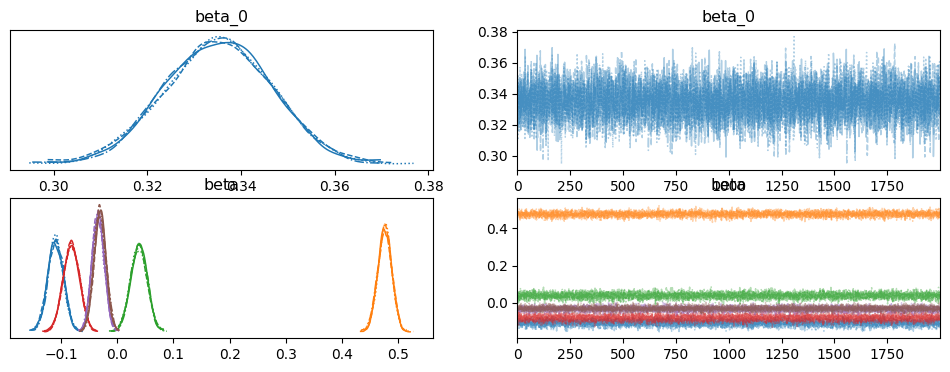

In [32]:
# Plot the trace
az.plot_trace(trace)

array([[<Axes: title={'center': 'beta_0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>],
       [<Axes: title={'center': 'beta\n5'}>, <Axes: >, <Axes: >]],
      dtype=object)

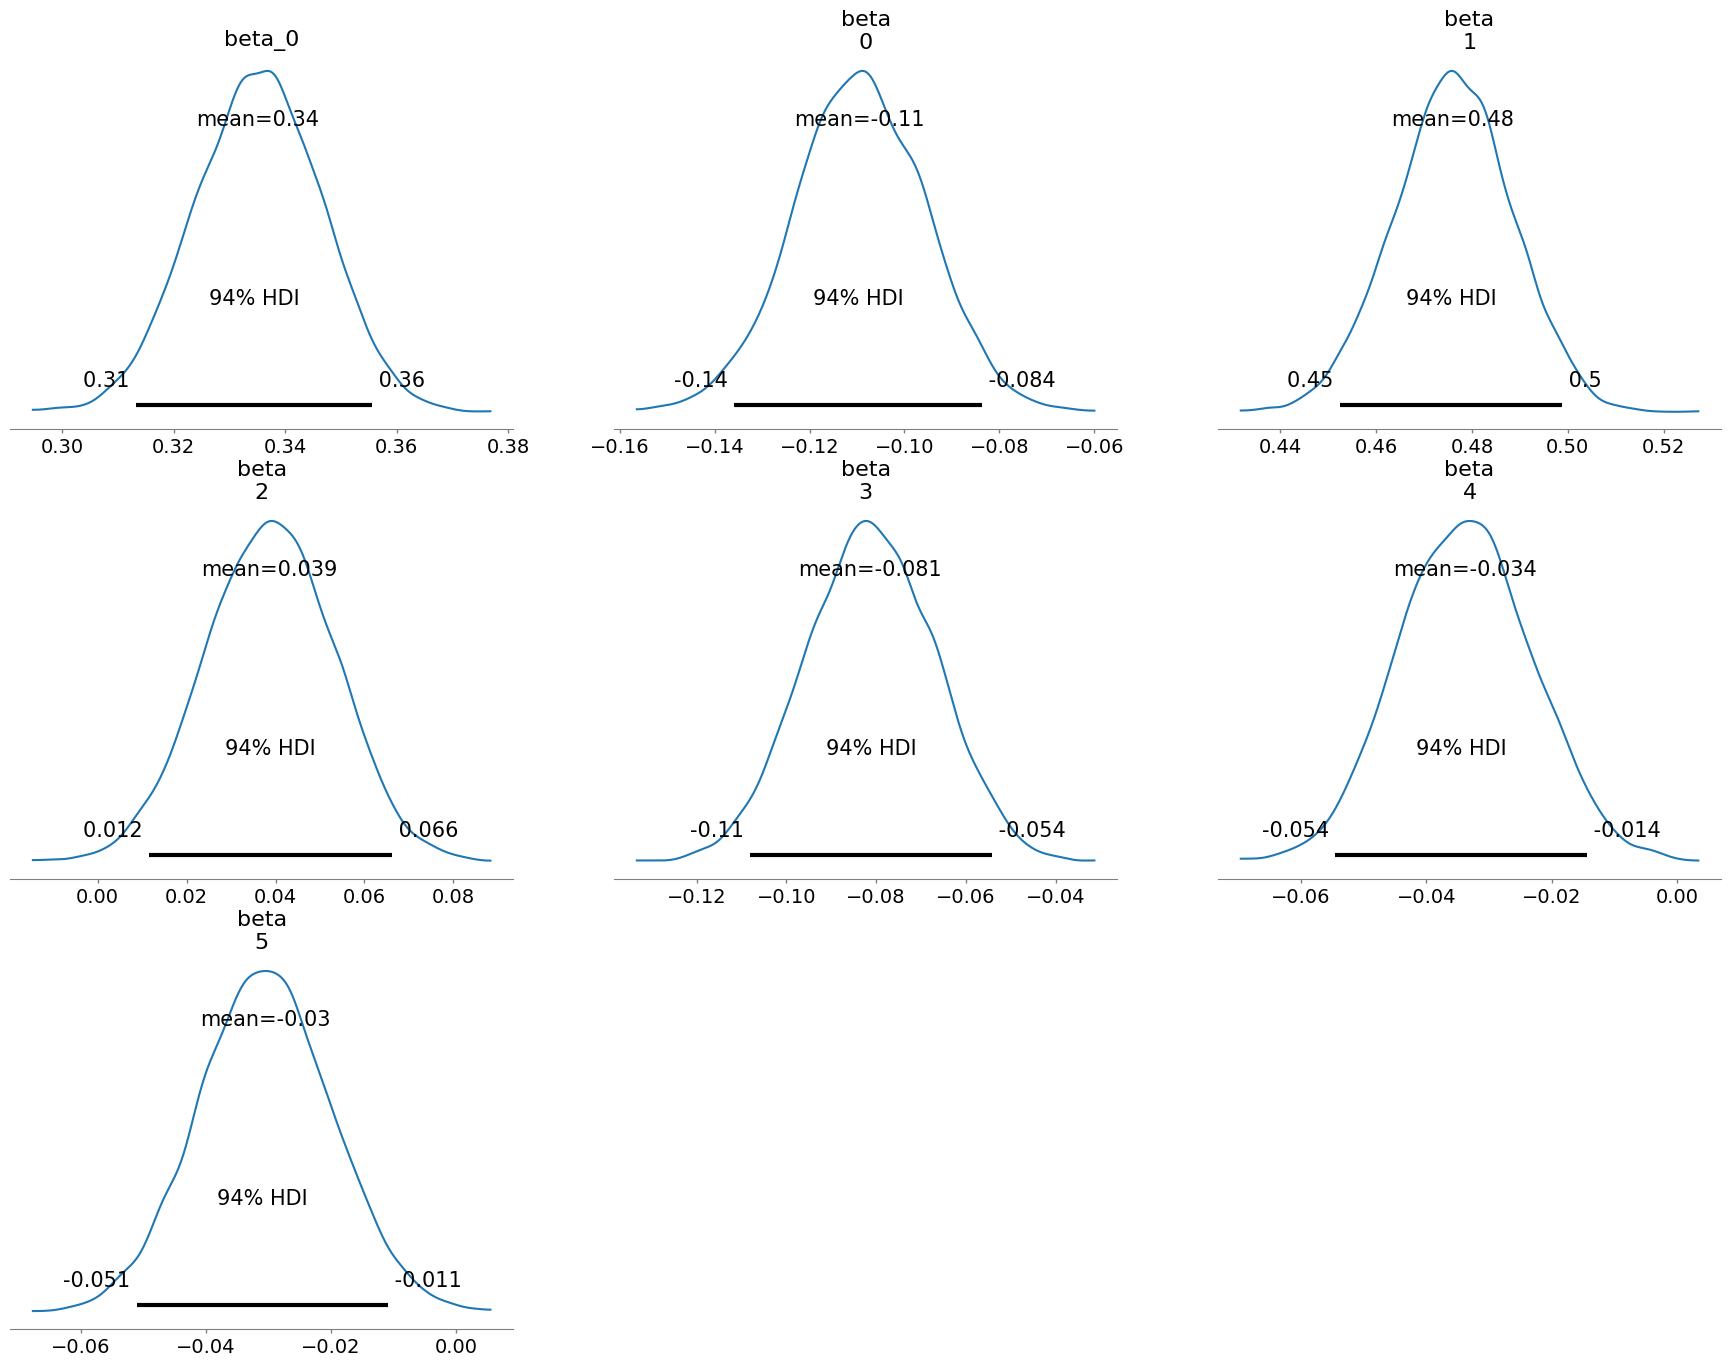

In [33]:
# Plot the posterior distributions
az.plot_posterior(trace)

In [34]:
# Display the trace summary
trace_summary = pm.summary(trace)
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,0.335,0.011,0.313,0.356,0.0,0.0,6611.0,5464.0,1.0
beta[0],-0.109,0.014,-0.136,-0.084,0.0,0.0,6571.0,5916.0,1.0
beta[1],0.476,0.012,0.453,0.499,0.0,0.0,6356.0,5760.0,1.0
beta[2],0.039,0.015,0.012,0.066,0.0,0.0,6108.0,5762.0,1.0
beta[3],-0.081,0.014,-0.108,-0.054,0.0,0.0,6464.0,5875.0,1.0
beta[4],-0.034,0.011,-0.054,-0.014,0.0,0.0,8203.0,6249.0,1.0
beta[5],-0.030,0.011,-0.051,-0.011,0.0,0.0,8227.0,6080.0,1.0


Sampling: [y_obs]


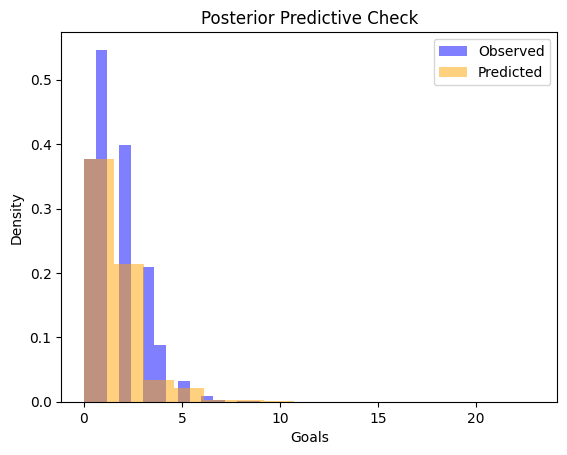

In [35]:
# Posterior predictive check
with model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Directly access observed data and posterior predictive samples
observed_data = ppc["observed_data"]["y_obs"].values  # Extract numpy array
posterior_predictive_samples = ppc["posterior_predictive"]["y_obs"].values  # Extract numpy array

# Plot observed vs predicted
plt.hist(observed_data, bins=15, alpha=0.5, label="Observed", color="blue", density=True)
plt.hist(
    posterior_predictive_samples.ravel(),  # Use ravel for flattening
    bins=15,
    alpha=0.5,
    label="Predicted",
    color="orange",
    density=True,
)
plt.legend()
plt.title("Posterior Predictive Check")
plt.xlabel("Goals")
plt.ylabel("Density")
plt.show()

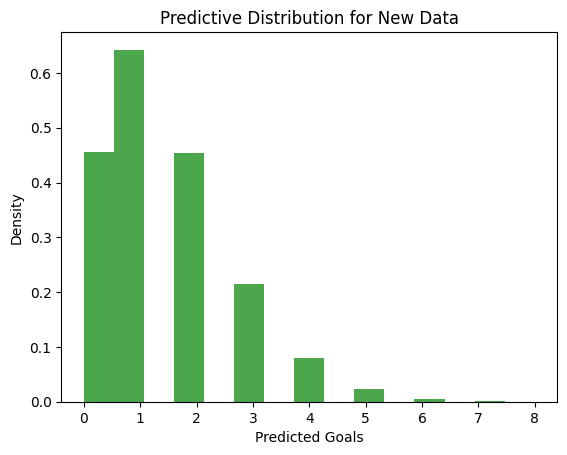

In [36]:
# Define new data for prediction (standardized input values)
new_data = np.array([[0.5, -0.3, 0.1, -0.2, 0.0, -0.1]])  # Example standardized inputs

# Compute the linear predictor for new data
linear_predictor = trace.posterior["beta_0"].values[:, :, None] + np.einsum(
    "ijk,lk->ijl", trace.posterior["beta"].values, new_data.T
)

# Compute lambda (Poisson rate parameter)
lambda_new = np.exp(linear_predictor)

# Generate samples from the predictive distribution
predicted_goals = np.random.poisson(lambda_new)

# Flatten the samples for visualization
predicted_goals_flat = predicted_goals.ravel()

# Plot predictive distribution for new data
import matplotlib.pyplot as plt

plt.hist(predicted_goals_flat, bins=15, alpha=0.7, color="green", density=True)
plt.title("Predictive Distribution for New Data")
plt.xlabel("Predicted Goals")
plt.ylabel("Density")
plt.show()
